In [3]:
code_dir = "../UXO_protected/+BTInvertPY"
import sys
sys.path.append(code_dir)

In [4]:
from BTSensor import SensorInfo, Model, preCalcLoopCorners, FModParam, forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
from BTInvert import getSettings, validate_std, signal2Noise, invert_single, invertML
import numpy as np
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
from matplotlib import rcParams
rcParams["font.size"]=14

In [33]:
data_directory = "../UXO_protected/data-blacktusk"

In [34]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [35]:
# Load the data file and read all data into a dictionary
# dfile = os.path.join('.','matlab','d190723_BlossomPointPOS_inv.h5')
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()
 
icell = '1'
iinv = '1' # it is common for the 1st inversion result to be 1-obj, 2nd: 2-obj and so on

In [36]:
dic.keys()

dict_keys(['CELLChannels', 'SensorConfig', 'SensorName', 'CELL', 'CELLInfo', 'SensorTimes', 'XYZ'])

In [37]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [38]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
# tx_comp = int(xyz_dict["Info"]["TxComp"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [39]:
xyz_data = xyz_dict["Data"]

# get a sense of the survey geometry

Text(0.5, 1.0, 'Test-plot \n data locations')

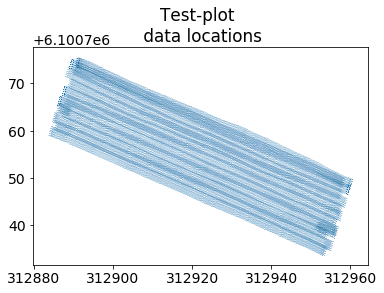

In [46]:
plt.plot(xyz_data[easting, :], xyz_data[northing, :], '.', alpha=0.1, ms=0.1);
plt.title("Test-plot \n data locations")

In [41]:
# plot a single measurement number
mn = xyz_data[mni, :].astype(int) - 1
print(mn.min(), mn.max())

0 164


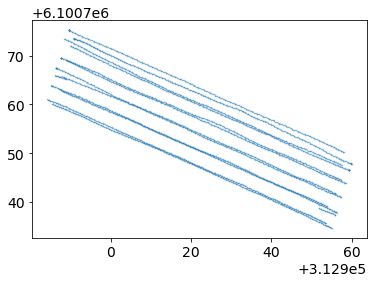

In [42]:
for plot_mn in range(1):
# plot_mn = 6
    inds = mn == plot_mn

    plt.plot(xyz_data[easting, inds], xyz_data[northing, inds], '.', alpha=0.5, ms=1)

In [43]:
lines = xyz_data[linesi, :].astype(int)
print(lines.min(), lines.max(), len(np.unique(lines)))

1001 1014 14


In [ ]:
np.unique(lines)
x0 = np.r_[xyz_data[easting, :].min(), xyz_data[northing, :].min()]
print(x0)

In [23]:
line_inds = lines == lines.min()
mn_inds = mn == 0
inds = line_inds & mn_inds

line_eastings = xyz_data[easting, inds]
line_northings = xyz_data[northing, inds]

dx = np.hstack([np.r_[0], np.diff(line_eastings)])
dy = np.hstack([np.r_[0], np.diff(line_northings)])

line_dl = np.sqrt(dx**2 + dy**2)
line_distances = np.cumsum(line_dl)

print(np.mean(line_dl))

0.21284075248176457


(6100753.69441273, 6100773.69441273)

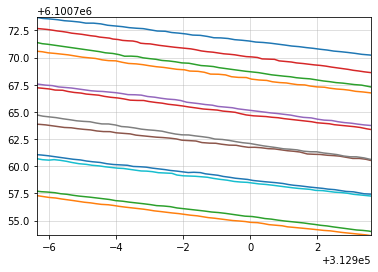

In [25]:
# line separations
line0 = lines == lines.min()
line1 = lines == lines.min() + 1
mn_inds = mn == 0

fig, ax = plt.subplots(1, 1)
for l in np.unique(lines):
    inds = mn_inds & (lines == l)
    line_eastings = xyz_data[easting, inds]
    line_northings = xyz_data[northing, inds]

    ax.plot(line_eastings, line_northings)
ax.grid(which="both", alpha=0.5)
ax.set_xlim(x0[0] + np.r_[10, 20])
ax.set_ylim(x0[1] + np.r_[20, 40])

In [26]:
xyz_data[rx_num, :]

array([ 1.,  1.,  1., ..., 11., 11., 11.])

0
1
2
3
4


(6100771.94441273, 6100772.19441273)

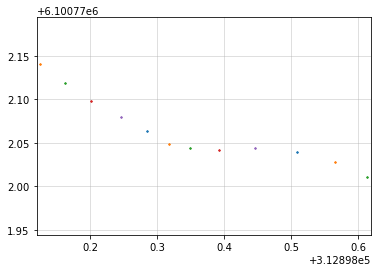

In [27]:
# how far apart are transmitter firings?
rx_inds = xyz_data[rx_num, :].astype(int) == 1
inds = rx_inds & (lines == lines.min())

fig, ax = plt.subplots(1, 1)

for i in range(5):
    print(i)
    indstx1 = inds & (xyz_data[tx_num,:].astype(int) == i+1)
    line_eastings = xyz_data[easting, indstx1]
    line_northings = xyz_data[northing, indstx1]
    ax.plot(line_eastings, line_northings, '.', ms=2)
ax.grid(which="both", alpha=0.5)
ax.set_xlim(x0[0] + np.r_[14.5, 15])
ax.set_ylim(x0[1] + np.r_[38.25, 38.5])

# plot some data

In [28]:
print(len(datai), len(times))

27 27


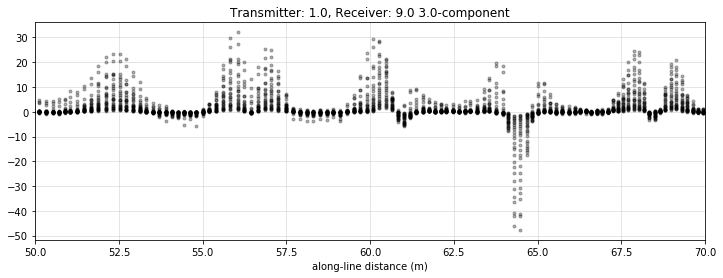

In [29]:
line_inds = lines == lines.max()
mn_inds = mn == 8
inds = line_inds & mn_inds

line_eastings = xyz_data[easting, inds]
line_northings = xyz_data[northing, inds]

dx = np.hstack([np.r_[0], np.diff(line_eastings)])
dy = np.hstack([np.r_[0], np.diff(line_northings)])

line_dl = np.sqrt(dx**2 + dy**2)
line_distances = np.cumsum(line_dl)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for t, dind in zip(times, datai):
    ax.plot(line_distances, xyz_data[dind, inds], '.', color="k", alpha=0.3)
    
txnumplot = np.unique(xyz_data[tx_num, inds])[0]
rxnumplot = np.unique(xyz_data[rx_num, inds])[0]
rxcompplot = np.unique(xyz_data[rx_comp, inds])[0]
ax.set_title(f"Transmitter: {txnumplot}, Receiver: {rxnumplot} {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")

ax.set_xlim([50, 70])
ax.grid(which="both", alpha=0.4)
    

In [30]:
tmp = np.zeros(mn.max())
for i in range(mn.max()):
    tmp[i] = np.sum(mn==i)

In [31]:
tmp

array([4554., 4554., 4557., 4557., 4557., 4557., 4560., 4563., 4563.,
       4563., 4563., 4554., 4554., 4557., 4557., 4557., 4557., 4560.,
       4563., 4563., 4563., 4563., 4554., 4554., 4557., 4557., 4557.,
       4557., 4560., 4563., 4563., 4563., 4563., 4554., 4554., 4557.,
       4557., 4557., 4557., 4560., 4563., 4563., 4563., 4563., 4554.,
       4554., 4557., 4557., 4557., 4557., 4560., 4563., 4563., 4563.,
       4563., 4554., 4554., 4557., 4557., 4557., 4557., 4560., 4563.,
       4563., 4563., 4563., 4554., 4554., 4556., 4556., 4556., 4556.,
       4558., 4560., 4560., 4560., 4560., 4554., 4554., 4556., 4556.,
       4556., 4556., 4558., 4560., 4560., 4560., 4560., 4554., 4554.,
       4556., 4556., 4556., 4556., 4558., 4560., 4560., 4560., 4560.,
       4554., 4554., 4556., 4556., 4556., 4556., 4558., 4560., 4560.,
       4560., 4560., 4554., 4554., 4556., 4556., 4556., 4556., 4558.,
       4560., 4560., 4560., 4560., 4554., 4554., 4556., 4556., 4556.,
       4556., 4558.,

In [ ]:
plt.plot(tmp, '.')

In [ ]:
len(times)